# Particle identification from detector response
---

### Physics Background
#### Inelastic scattering

The inelastic scattering is a process used to probe the inside structure of hadrons, in this case protons. In this process a incident particle (photoelectron) collides with a target proton. The kinetic energy of the incident particle is not conserved after the collision. During inelastic scattering a proton can break up into its constituent quarks which then form a hadronic jet. The angles of the deflection gives information about the nature of the process.

#### The Standard Model

The building blocks of matter are elementary particles. These particles are divided in two major types: quarks and leptons. The Standard Model also studies the interaction of these particles through fundamental forces (strong, weak and electromagnetic). For every type of particle there also exists a corresponding antiparticle.

**Quarks** are fundamental constituents of matter because they combine to form hadrons. There are six quarks paired in three groups: "up/down", "charm/strange" and "top/bottom". They are held together through strong forces.

**Hadrons** They divide in Baryons and Mesons. Baryons are made of three quarks. For example protons are made of (uud) quarks and neutrons are made of (udd) quarks. Mesons contain one quark and one antiquark. An example of a meson is a pion which is made of an up quark and a down antiquark. Another example of a meson is kaon, it is formed by a up or down quark and a anti-strange quark.

**Leptons** have a 1/2 spin and do not undergo strong interactions. There are six leptons, three of wich have an electrical charge. These are: electron, muon and tau. The three remaining are neutrinos. A positron is the antiparticle counterpart of an electron. It possess the same mass and spin but positive charge.

### Datasets

The data is provided at this link: https://cernbox.cern.ch/index.php/s/4GSHq223r6EBaeU

It is a simulation of electron-proton inelastic scattering measured by a particle detector system.

**Goal** you will have to detect **4 particle types**. Your **label** is the particle ID, listed below: 
- positron (-11), 
- pion (211), 
- kaon (321),
- proton (2212); 

The **features** provided to identify particles are six detector responses. Some detector responses are zero due to detector inefficiencies or incomplete geometric coverage of the detector.

The features are listed below:
- **p** momentum (GeV/c)
- **theta** (rad)
- **beta**
- **nphe** number of photo-electrons
- **ein** inner energy (GeV)
- **eout** outer energy (GeV)

The dataset is already splitted below into training and test datasets.

## Loading in data
---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from tensorflow.python.keras.models import Model
from tensorflow.keras.layers import Dense,Flatten,Dropout,Input
from tensorflow.python.keras.models import Sequential
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [2]:
# read the dataset
data = pd.read_csv( "pid-5M.csv")

In [3]:
print(data.shape)
print(np.unique(data['id']))
data.isnull().sum()

(5000000, 7)
[ -11  211  321 2212]


id       0
p        0
theta    0
beta     0
nphe     0
ein      0
eout     0
dtype: int64

In [4]:
data.describe()

,id,p,theta,beta,nphe,ein,eout
count,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06
mean,9.941839e+02,1.230053e+00,4.889321e-01,8.995796e-01,3.575243e+00,5.635883e-02,7.033195e-02
std,9.724034e+02,7.414895e-01,2.942161e-01,1.132321e-01,1.779236e+01,7.882675e-02,1.020604e-01
min,-1.100000e+01,2.101170e-01,9.222140e-02,5.500010e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.110000e+02,6.657510e-01,2.817420e-01,8.378760e-01,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.110000e+02,1.066150e+00,4.048670e-01,9.461940e-01,0.000000e+00,3.442440e-02,4.417490e-02
75%,2.212000e+03,1.649650e+00,6.117800e-01,9.855910e-01,0.000000e+00,6.834520e-02,9.365990e-02
max,2.212000e+03,5.286950e+00,2.219270e+00,1.499590e+00,3.490000e+02,8.993820e-01,1.097410e+00


## Data Visualisation

In [5]:
labels_names = ['Positron',"Pion","Kaon","Proton"]
id_names = np.unique(data['id'])

Here we will create a sample dataset to visualise the data, this will allow us to see into the weights of each feature to estimate before we create our models which parameters will provide the best insight into the classification of the hadrons. First we will create a smaller sample dataset, randomise its elements and select the first 100 of each unique particle. From this we can create a correlation plot to see how each of the features behave relative to each other. Some of the values in the dataset upon inspection appear to be zero, this is apparently due to the detector inefficiencies, it was decided to not drop these values from the studies to see how the model handles these sorts of hurdles. 

In [6]:
keys = [-11,211,321,2212] # particle identifiers to assign Label name in the sample
sample = data.copy()
sample['Label'] = sample['id'].apply(lambda itype: labels_names[keys.index(itype)]) # Map the ids in data set to its label name
sample = sample.drop(['id'],axis=1) # Remove the id column (not needed now we have the label names)
frames = []
# First 100 observations per each hadron
for t in labels_names:
    # Create Boolean Mask to select hadron
    mask = sample['Label'] == t
    frames.append(sample[mask].head(100))
# Concatenate the frames
sample = pd.concat(frames)
sample.groupby('Label')['Label'].count() # Count how many instances there are of each particle (should be 100 each)

Label
Kaon        100
Pion        100
Positron    100
Proton      100
Name: Label, dtype: int64

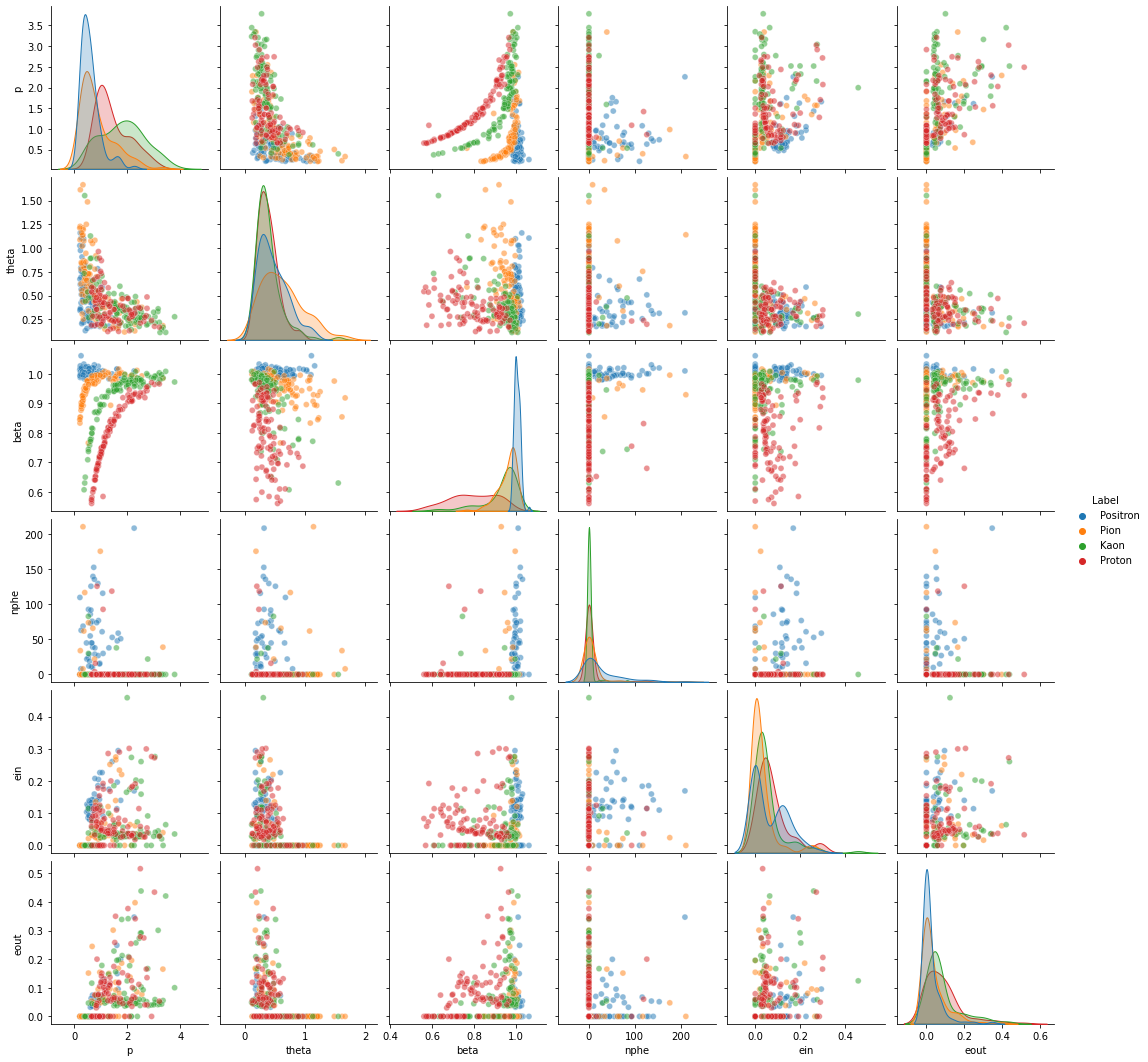

In [7]:
sns.pairplot(sample,hue = 'Label',plot_kws={'alpha':0.5}) # Creates correlation plot sorted by Label
# Reduced alpha to improve plot visability

From the correlation plot we can identify the key feature of the data that we assume our machine learning models will provide large weightings to in order to correctly classify the particles. For example we expect that the momentum and the beta features will have significant impact on classification as we can see the clearest distinction between the different particles. Also we predict that the number of photoelectrons (nphe) will also play a large role in estimating the Positrons because the other particles seem to mostly have 0 photoelectrons making the postirons clear outliers.

## Data Preprocessing

### Split dataset into training and test

In [8]:
data.head()

,id,p,theta,beta,nphe,ein,eout
0,211,0.780041,1.081480,0.989962,0,0.000000,0.000000
1,211,0.260929,0.778892,0.902450,0,0.000000,0.000000
2,2212,0.773022,0.185953,0.642428,4,0.101900,0.000000
3,211,0.476997,0.445561,0.951471,0,0.000000,0.000000
4,2212,2.123290,0.337332,0.908652,0,0.034379,0.049256


In [9]:
data.groupby('id')['id'].count()

id
-11        14847
 211     2806833
 321      232471
 2212    1945849
Name: id, dtype: int64

In [10]:
# This section of code creates an even split of each number of particles for the model to predict
# 13,000 of each particles
# If you want the whole data set instead comment this block of code out (might have to reduce number of epochs in models later on)
# For the code to run in a managable time


dataframes = []
for t in id_names:  
    mask = data['id'] == t # Create Boolean Mask to select hadron
    dataframes.append(data[mask].head(13000)) # First 13000 observations per each hadron
data = pd.concat(dataframes) # Concatenate the frames
data.groupby('id')['id'].count()

id
-11      13000
 211     13000
 321     13000
 2212    13000
Name: id, dtype: int64

In [11]:
X = data.drop('id',axis=1 ,inplace=False)
y=pd.get_dummies(data['id'])

In [12]:
features = data.drop('id', axis=1)
labels = data['id']
data.head()

,id,p,theta,beta,nphe,ein,eout
143,-11,0.965438,0.175186,0.999518,16,0.226139,0.000000
279,-11,1.430840,0.266338,1.000610,53,0.260426,0.056901
1374,-11,0.315557,0.222151,0.997282,0,0.000000,0.000000
1916,-11,0.885481,0.782970,1.001940,0,0.000000,0.000000
1964,-11,0.698711,0.329893,0.996576,39,0.120439,0.000000


In [13]:
#test and train split using sklearn.model_selection
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size = 0.22, random_state = 1)

#### OneHotEncoding

At the moment the label identifiers for the particles are as follows: 
- positron (-11),
- pion (211),
- kaon (321),
- proton (2212);

In this format it is very difficult for any type of classifier to assign a correct identifier to a set of parameters, because of this we use a OneHot encoder to to split up the y_train and y_test (identifying labels) into an array of length 4 where each element represents a unique label (eg. [1,0,0,0] might possible represent a positron, depending on the input order of the OneHot encoder). A column will be created for each output category and a binary variable is inputted for each category.

In [14]:
def oneHotenc(values):
    # function that takes in an list and returns it hotencoded the unique features of list
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    return onehot_encoded

y_train = oneHotenc(y_train) # The two target lists (the particle ids) are what we want to hotencode in this case
y_test = oneHotenc(y_test)

## Decision Tree

In this section I will create a decision tree that predicts the binary classification of the hadrons by partitioning the data recursively until each partition region contains a single target value. We can tune the parameters of the tree to find the best accuracy score, in this decision tree the parameter that we can modify is the maximum depth. This determines how deep the tree goes, we expect that the smaller the maximum depth the worse accuracy score we will obtain, on the other hand the larger the maximum depth the higher the chance of overfitting. In this study we will create three different decision trees each with different maximum depths: 2,4,6. We will the compare the accuracy scores.

In [15]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.tree import export_graphviz
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn import metrics

##### Decision Tree (Max_Depth = 2)

In [16]:
# Create Decision Tree classifer object with these parameters
dt = DecisionTreeClassifier(criterion = 'entropy',max_depth = 2)
# Train Decision Tree Classifer
dt = dt.fit(x_train,y_train)

In [17]:
#Prediction
y_pred2 = dt.predict(x_test)
#Accuracy
print("Accuracy:",metrics.accuracy_score(y_test, y_pred2))

Accuracy: 0.6594405594405595


We can see that this shallow tree (Max_Depth=2) results in a poor accuracy result, we expect that the greater the depth of the tree the higher the accuracy score and better predictions, with the trade off of computational time and overfitting for high max depth values.

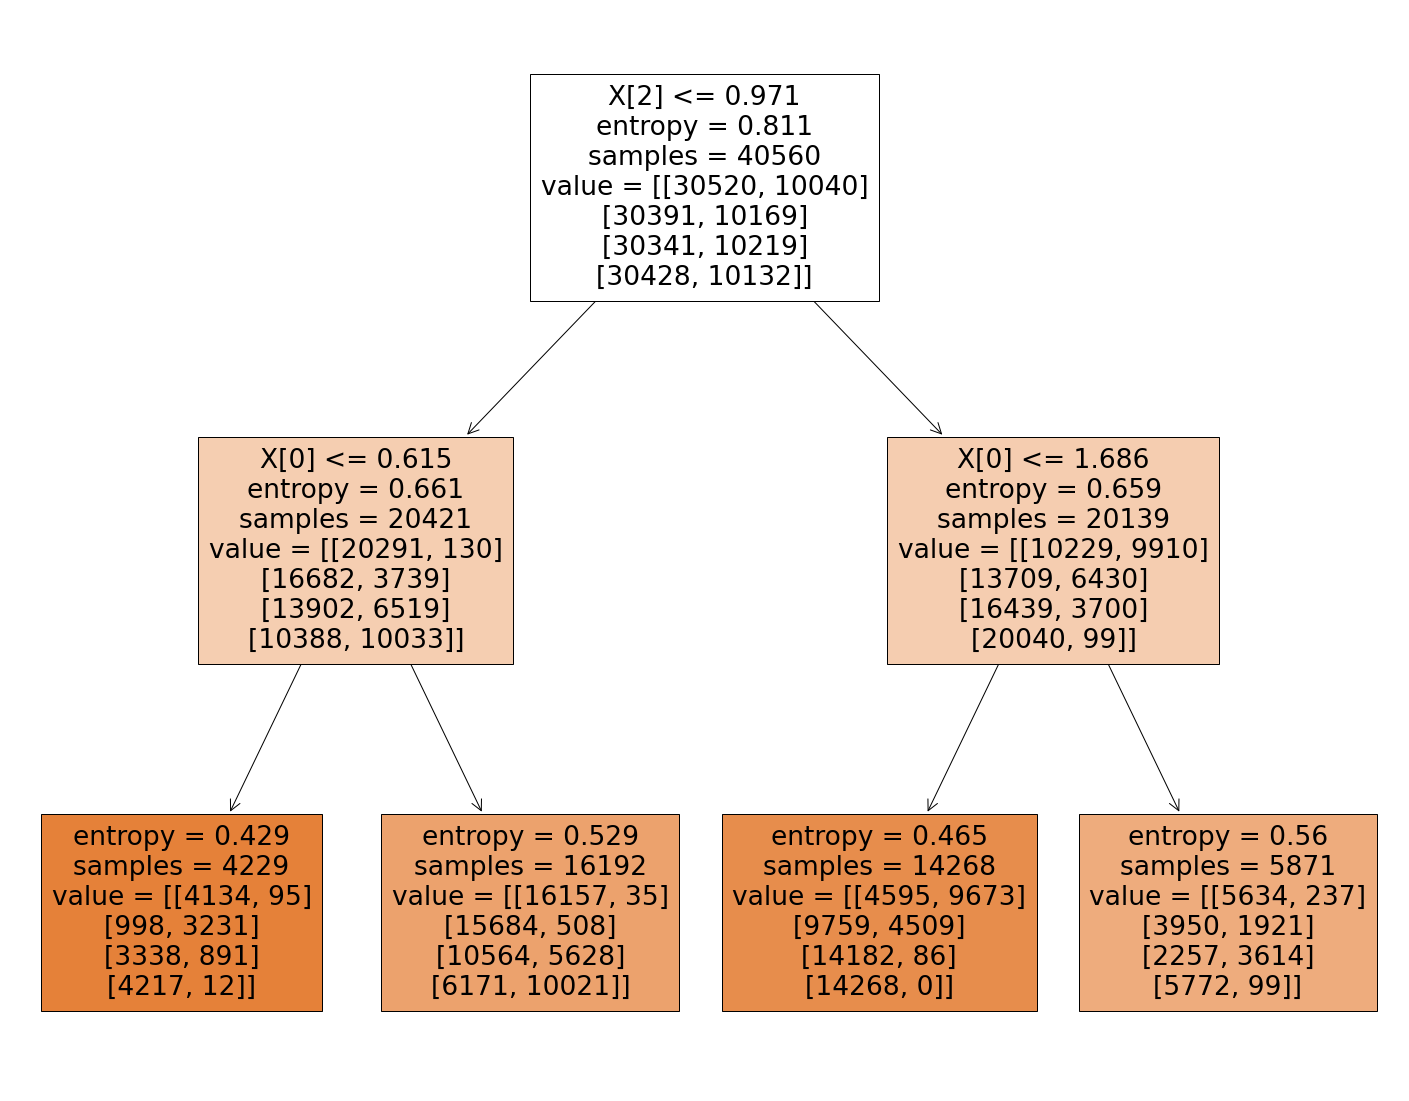

In [18]:
# Creates decision tree graph
export_graphviz(dt,
                out_file="Hadron_tree.dot",
                rounded=True,
                filled=True
               )
#save the decision_tree as png
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dt, 
                   filled=True)
fig.savefig("decision_tree2.png")

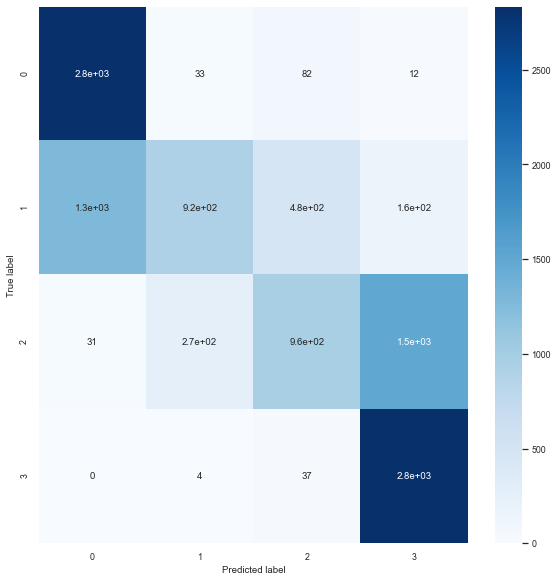

In [19]:
# Create a confusion matrix from the test predictions
confusion_rand = confusion_matrix(np.argmax(y_test,axis=1), np.argmax(y_pred2,axis=1))
figure = plt.figure(figsize=(8, 8))
sns.set(font_scale=0.8)
sns.heatmap(confusion_rand, annot=True,cmap=plt.cm.Blues)
#plt.matshow(confusion)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

This confusion matrix shows us the particles that are getting predicted correctly, the diagonal terms are the true positive results while the off diagonal are the false positives. We can see that for a max depth of 2 that the model has a difficult time classifying correctly, mispredicting label 3 as 2 and 0 as 1 often.

##### Decision Tree (Max_Depth = 4) 

In [20]:
# Create Decision Tree classifer object with these parameters
dt4 = DecisionTreeClassifier(criterion = 'entropy',max_depth = 4)
# Train Decision Tree Classifer
dt4 = dt4.fit(x_train,y_train)

In [21]:
#Prediction
y_pred4 = dt4.predict(x_test)
#Accuracy
print("Accuracy:",metrics.accuracy_score(y_test, y_pred4))

Accuracy: 0.8216783216783217


We see that increasing the depth increase the accuracy score by ~15%

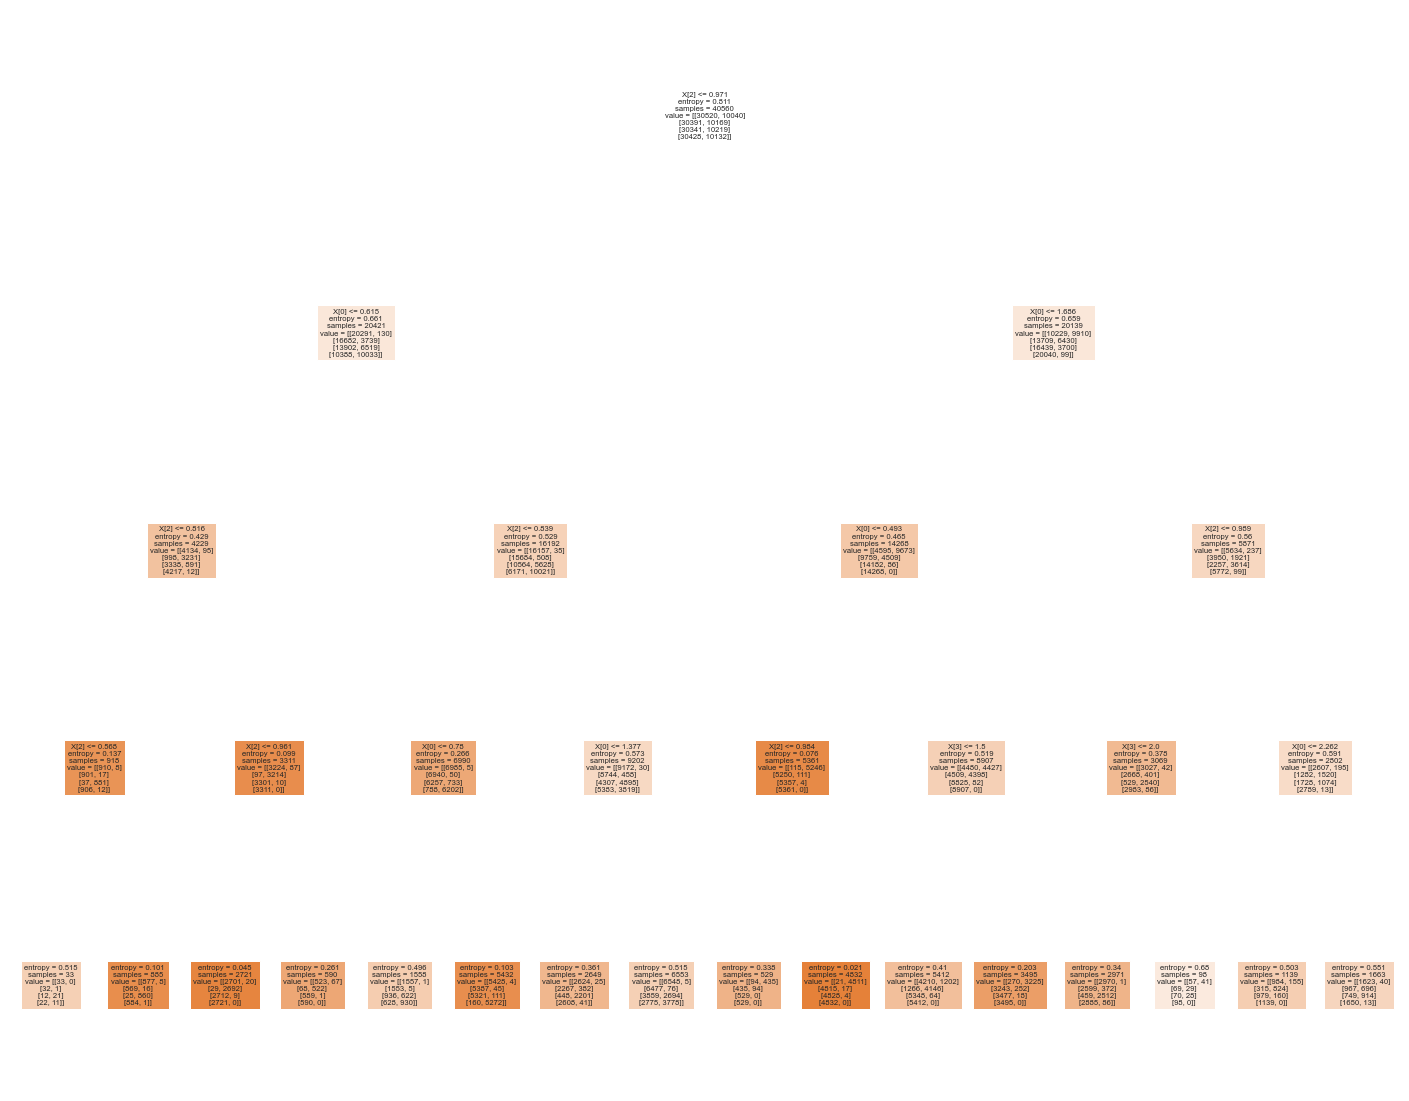

In [22]:
# Creates decision tree graph
export_graphviz(dt4,
                out_file="Hadron_tree.dot",
                rounded=True,
                filled=True
               )
#save the decision_tree as png
fig4 = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dt4, 
                   filled=True)
fig4.savefig("decision_tree4.png")

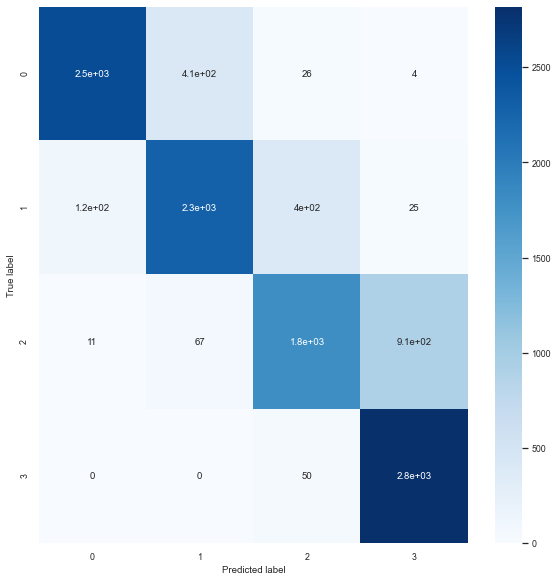

In [23]:
# Create a confusion matrix from the test predictions
confusion_rand = confusion_matrix(np.argmax(y_test,axis=1), np.argmax(y_pred4,axis=1))
figure = plt.figure(figsize=(8, 8))
sns.set(font_scale=0.8)
sns.heatmap(confusion_rand, annot=True,cmap=plt.cm.Blues)
#plt.matshow(confusion)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

As we increase the depth of the tree we see that the diagonal terms in the confusion matrix become more prominent as expected. We expect this accuracy to further increase as we increase the maximum depth further.

##### Decision Tree (Max_Depth = 6)

In [24]:
# Create Decision Tree classifer object with these parameters
dt6 = DecisionTreeClassifier(criterion = 'entropy',max_depth = 6)
# Train Decision Tree Classifer
dt6 = dt6.fit(x_train,y_train)

In [25]:
#Prediction
y_pred6 = dt6.predict(x_test)
#Accuracy
print("Accuracy:",metrics.accuracy_score(y_test, y_pred6))

Accuracy: 0.920979020979021


This is the highest accuracy score so far, we expect that by further increasing the depth we will encounter overfitting of the data.

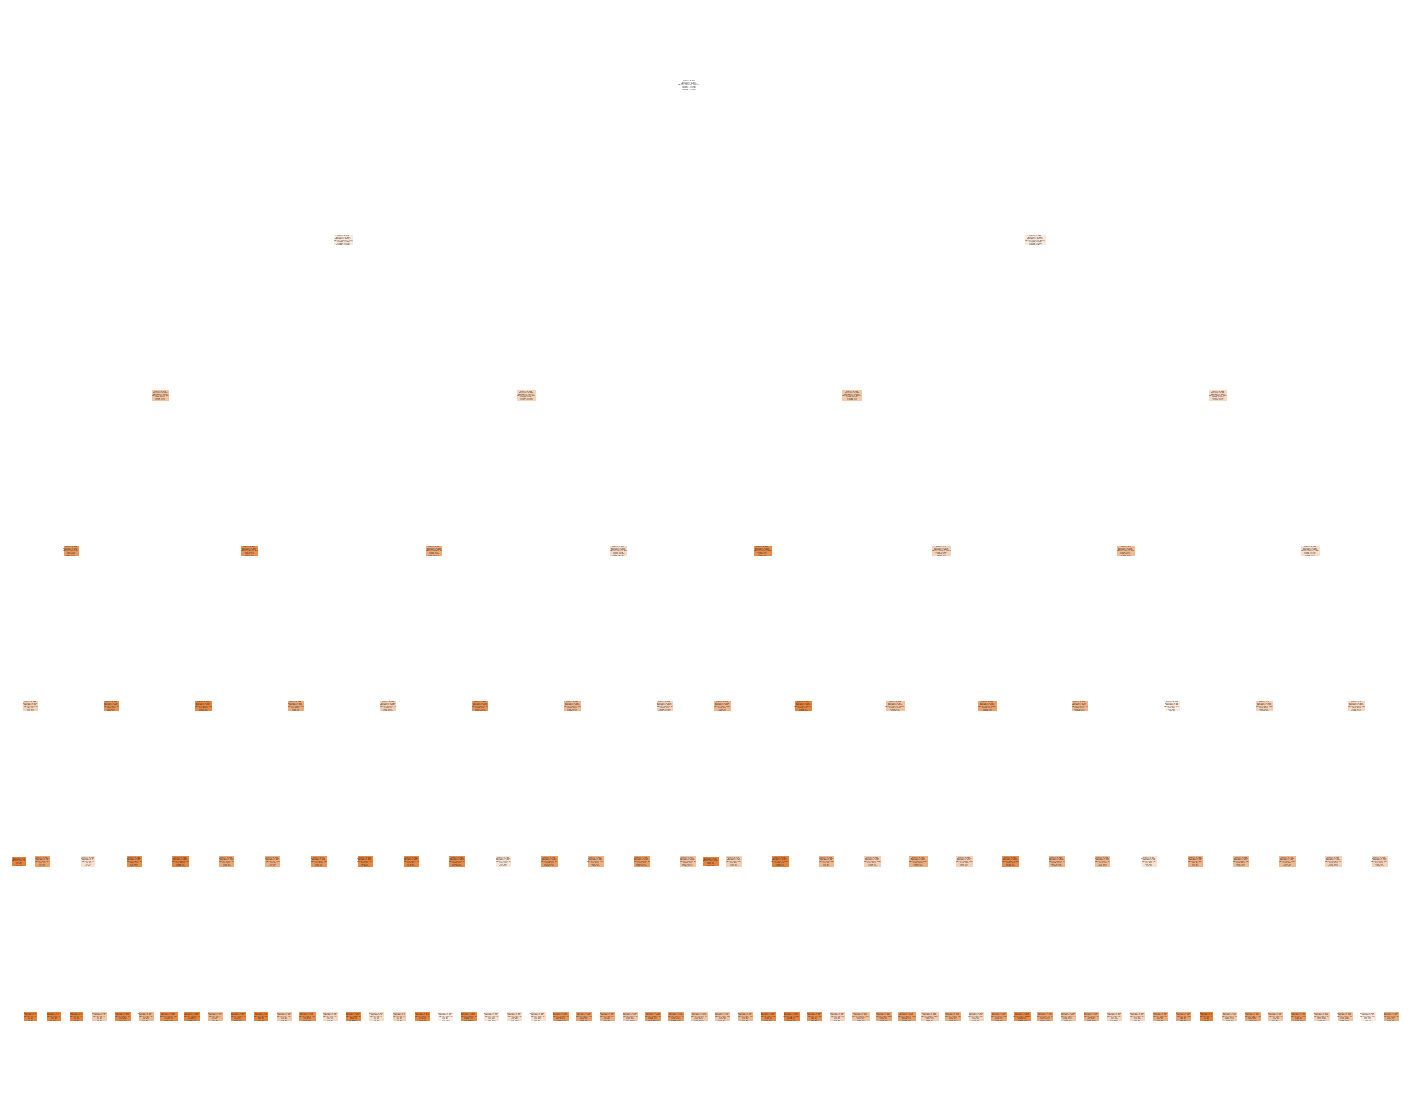

In [26]:
# Creates decision tree graph
export_graphviz(dt6,
                out_file="Hadron_tree.dot",
                rounded=True,
                filled=True
               )
#save the decision_tree as png
fig6 = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dt6, 
                   filled=True)
fig6.savefig("decision_tree10.png")

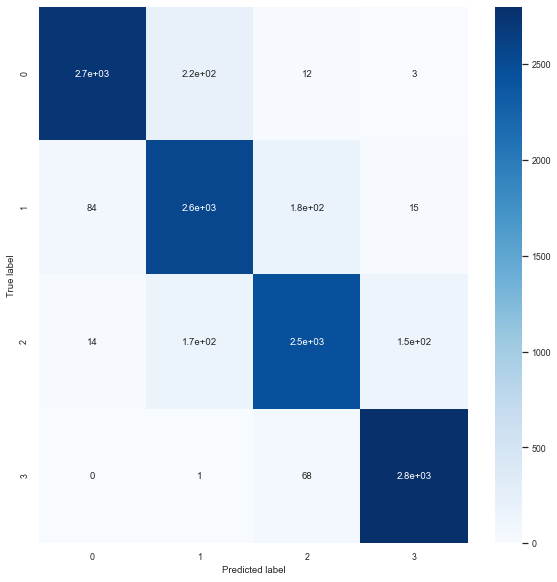

In [27]:
# Create a confusion matrix from the test predictions
confusion_rand = confusion_matrix(np.argmax(y_test,axis=1), np.argmax(y_pred6,axis=1))
figure = plt.figure(figsize=(8, 8))
sns.set(font_scale=0.8)
sns.heatmap(confusion_rand, annot=True,cmap=plt.cm.Blues)
#plt.matshow(confusion)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Here the deepest tree produces the highest accuracy score as predicted, the confusion matrix shows that the diagonal terms are orders of magnitude larger than the off diagonals showing that the model is again predicting very accurately.

## Decision Tree Classifier Gradient Boosted

Here we create a gradint boosting tree, it combines multiple decision trees to create a more powerful model. It creates its trees in a serial manner correcting the mistakes of the previous tree. Often they are very shallow so will use up little memory and predict very fast.

In [28]:
# Create Decision Tree classifer object with these parameters
ys = []
ys_test = []
# Gradient booster cannot deal with hotencoded data so we revert back to index identification for y_train and y_test
for t in y_train:
    ys.append(np.argmax(t))
for t in y_test:
    ys_test.append(np.argmax(t))
    
bdt = GradientBoostingClassifier(max_depth=4, n_estimators=20) # Boosted tree classifier
#Fit
bdt.fit(x_train, ys)
#Prediction
y_pred_grad = bdt.predict(x_test)
#Accuracy
print("Accuracy:",metrics.accuracy_score(ys_test, y_pred_grad))

Accuracy: 0.9375874125874126


The Gradient boosted classifier produces a high accuracy score ~90%, even with a shallow depth of 4, compared to the normal decision tree at depth 4 we see that the gradient boosted performs better by 10%

## Decision Tree Classifier Random Forrest

A random forest tree classifier identifies the issue of overfitting, it works by building many trees to reduce the overfitting of each individual tree which in turn reduces the overall by averaging their results. The hyperparameters in this case are the number of estimators and the maximum depth, for this example we have choosen 20 estimators and a maximum depth of 7.

In [29]:
# Fit a random forest classifier
rf = RandomForestClassifier(n_estimators=20, max_depth=7) # Random Forrest
#Fitting
rf.fit(x_train, y_train)
# Prediction
y_pred_rand = rf.predict(x_test)

In [30]:
# Accuracy
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_rand))

Accuracy: 0.9082167832167832


Here the random forest has a deeper max depth but it performs worse than both the normal decision tree and the gradient boosted tree, this is unexpected but could be due to these being shallow trees in general which means little overfitting of data so the benefits of the random forrest arent experienced until higher depths. 

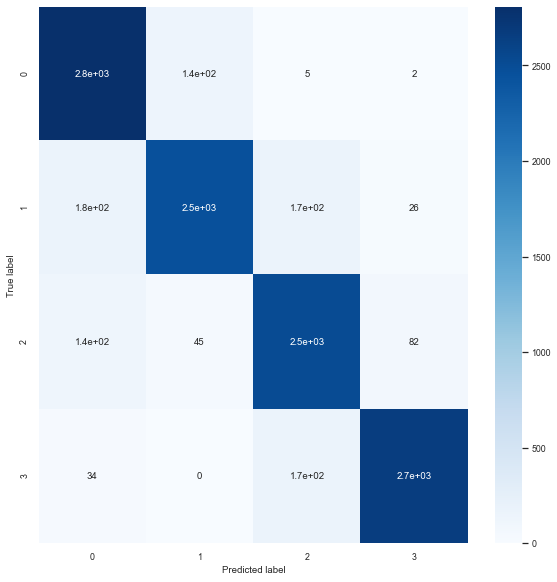

In [31]:
# Create a confusion matrix from the test predictions
confusion_rand = confusion_matrix(np.argmax(y_test,axis=1), np.argmax(y_pred_rand,axis=1))
figure = plt.figure(figsize=(8, 8))
sns.set(font_scale=0.8)
sns.heatmap(confusion_rand, annot=True,cmap=plt.cm.Blues)
#plt.matshow(confusion)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Once again the diagonal terms in the confusion matrix show the correctly predicted results and the off diagonals the incorrectly predicted results, the heat map clearly shows that the diagonal terms are the most significant which is a result of the high accuracy of the model. 

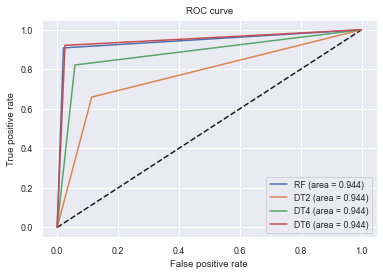

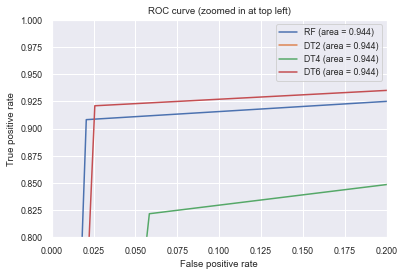

In [32]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# This section of code creates a ROC curve for each of the decision tree models to compare them.
# Calculates roc values for each tree
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test.ravel(), y_pred_rand.ravel())
fpr_2, tpr_2, thresholds_2= roc_curve(y_test.ravel(), y_pred2.ravel())
fpr_4, tpr_4, thresholds_4= roc_curve(y_test.ravel(), y_pred4.ravel())
fpr_6, tpr_6, thresholds_6= roc_curve(y_test.ravel(), y_pred6.ravel())

auc_rf = auc(fpr_rf, tpr_rf)
auc_2 = auc(fpr_2, tpr_2)
auc_4 = auc(fpr_4, tpr_4)
auc_10 = auc(fpr_6, tpr_6)



# Plots the figure
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')

plt.plot(fpr_rf,tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.plot(fpr_2, tpr_2, label='DT2 (area = {:.3f})'.format(auc_rf))
plt.plot(fpr_4, tpr_4, label='DT4 (area = {:.3f})'.format(auc_rf))
plt.plot(fpr_6, tpr_6, label='DT6 (area = {:.3f})'.format(auc_rf))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf,tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.plot(fpr_2, tpr_2, label='DT2 (area = {:.3f})'.format(auc_rf))
plt.plot(fpr_4, tpr_4, label='DT4 (area = {:.3f})'.format(auc_rf))
plt.plot(fpr_6, tpr_6, label='DT6 (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

We can see from the following ROC curve that the decision tree with depth 6 and the random forest with depth 6 are very similar in terms of the true positive rates. As the depth of the tree decreases the true positive rate also decreases which leaves us the decision tree of depth two performing the worst as expected. For formatting reasons it was not possible to get the gradient boosting tree to work to get an ROC curve due to the nature of it rejecting hotencoded data.

## Deep Neural Network Classifier

In this study we will create a deep neural network classifier for our first model we will have 3 hidden layers of activation function relu and a single output layer with activation softmax with the output size the same as our hotencoded target variables.

In [33]:
input = Input(shape=(6,))  # Input is each of our test features (p,beta,ein,eout...)
lay1 = Dense(10, activation='relu')(input) # 3 Hidden dense layers of activation function 'relu'
lay2 = Dense(30, activation='relu')(lay1)
lay3 = Dense(50, activation='relu')(lay2)
output = Dense(4, activation='softmax')(lay3) # Output layer with size 4, for each unique particle ids
model = Model(input, output) # Create model from layers
model.compile(loss='binary_crossentropy', optimizer="adam",metrics=['accuracy']) # Compile using binary crossentropy loss function
model.summary() # Print summary of the model

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6)]               0         
_________________________________________________________________
dense (Dense)                (None, 10)                70        
_________________________________________________________________
dense_1 (Dense)              (None, 30)                330       
_________________________________________________________________
dense_2 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 204       
Total params: 2,154
Trainable params: 2,154
Non-trainable params: 0
_________________________________________________________________


Here we see the summary of the model, we can clearly see the three hidden dense layers and the input and output, this combined with the architecture of the model provides a total number of 2,154 trainable parameters.

In [34]:
# fit the model with the hyperparameters: 2 epochs and batch size=32, reserve some of the dataset for validation
history = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.2,shuffle=True)

Epoch 1/100
1014/1014 [==============================] - 8s 5ms/step - loss: 0.5127 - accuracy: 0.4762 - val_loss: 0.3958 - val_accuracy: 0.6323
Epoch 2/100
1014/1014 [==============================] - 3s 3ms/step - loss: 0.3673 - accuracy: 0.6536 - val_loss: 0.2947 - val_accuracy: 0.7377
Epoch 3/100
1014/1014 [==============================] - 4s 4ms/step - loss: 0.2797 - accuracy: 0.7808 - val_loss: 0.2365 - val_accuracy: 0.8401
Epoch 4/100
1014/1014 [==============================] - 3s 3ms/step - loss: 0.2219 - accuracy: 0.8550 - val_loss: 0.1965 - val_accuracy: 0.8706
Epoch 5/100
1014/1014 [==============================] - 4s 4ms/step - loss: 0.1866 - accuracy: 0.8825 - val_loss: 0.1783 - val_accuracy: 0.8815
Epoch 6/100
1014/1014 [==============================] - 4s 4ms/step - loss: 0.1745 - accuracy: 0.8861 - val_loss: 0.1570 - val_accuracy: 0.8951
Epoch 7/100
1014/1014 [==============================] - 4s 4ms/step - loss: 0.1518 - accuracy: 0.8987 - val_loss: 0.1553 - val_ac

1014/1014 [==============================] - 4s 4ms/step - loss: 0.0986 - accuracy: 0.9273 - val_loss: 0.1130 - val_accuracy: 0.9168
Epoch 58/100
1014/1014 [==============================] - 3s 3ms/step - loss: 0.0955 - accuracy: 0.9277 - val_loss: 0.0972 - val_accuracy: 0.9253
Epoch 59/100
1014/1014 [==============================] - 3s 3ms/step - loss: 0.0941 - accuracy: 0.9306 - val_loss: 0.1000 - val_accuracy: 0.9299
Epoch 60/100
1014/1014 [==============================] - 3s 3ms/step - loss: 0.0959 - accuracy: 0.9258 - val_loss: 0.1202 - val_accuracy: 0.9063
Epoch 61/100
1014/1014 [==============================] - 3s 3ms/step - loss: 0.0962 - accuracy: 0.9267 - val_loss: 0.1006 - val_accuracy: 0.9289
Epoch 62/100
1014/1014 [==============================] - 3s 3ms/step - loss: 0.0952 - accuracy: 0.9279 - val_loss: 0.1206 - val_accuracy: 0.9105
Epoch 63/100
1014/1014 [==============================] - 3s 3ms/step - loss: 0.0969 - accuracy: 0.9271 - val_loss: 0.0995 - val_accuracy

In [35]:
train = model.evaluate(x_train,y_train) # test on training set
test = model.evaluate(x_test,y_test) # test on test set

358/358 [==============================] - 1s 2ms/step - loss: 0.0895 - accuracy: 0.9324


This model creates the highest accuracy score of all the models we have so far made ~96%.

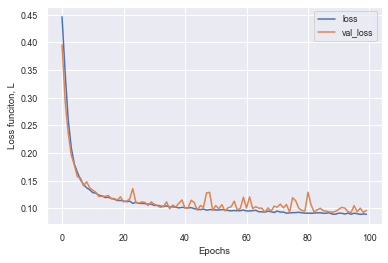

In [36]:
# Plot the validation loss of the model
plt.plot(history.history['loss'],label="loss")
plt.plot(history.history['val_loss'],label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss funciton, L")
plt.legend()
plt.show()

From this loss graph we can see that the validation loss follows the loss as expected and no divergence has been observed so far which suggests that our model after 100 epochs is not overfitting its data.

In [37]:
test_data = model.predict(x_test) # Find the predictions for the model on our test data set

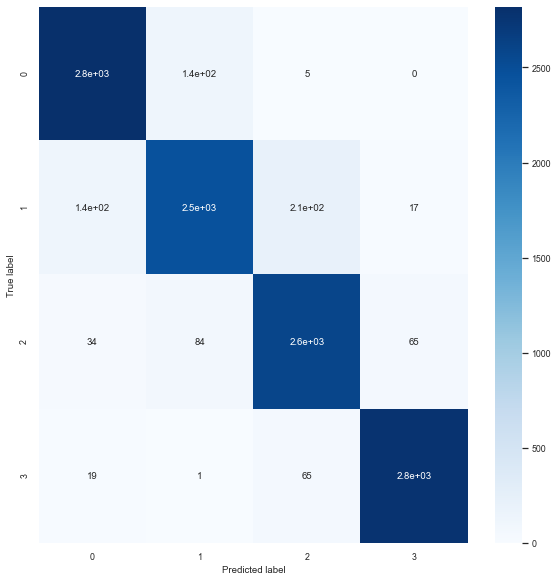

In [38]:
# Create a confusion matrix from the test predictions
confusion = confusion_matrix(np.argmax(y_test,axis=1), np.argmax(test_data,axis=1))
figure = plt.figure(figsize=(8, 8))
sns.set(font_scale=0.8)
sns.heatmap(confusion, annot=True,cmap=plt.cm.Blues)
#plt.matshow(confusion)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

####  Different Hyperparameter 

Some of the hyperparameters that we can change in the model:
- Number of hidden layers
- Number of dropout layers
- Activation function
- Learning rate
- Number of epochs 
- Batch size

By changing these hyperparameters our model will be completely different, by doing so we can compare the two models we have created to see which one produces the best accuracy score finding the values of each hyperparameter which helps the model provide the most accurate predictions.
In this second model we will implement a single dense hidden layer with a total of 114 trainable parameters, we will also keep the number of epochs at 100 (4 if whole dataset used and not equal number of particles) so we can meaningfully compare the validation loss of the two models. Also we will change the activation function on the output to 'sigmoid' and reduce the batch size to 16.

In [39]:
input = Input(shape=(6,)) # input layer same size as our feature list
lay1 = Dense(10, activation='relu')(input) # hidden dense layer activation relu
output = Dense(4, activation='sigmoid')(lay1) # output layer activation sigmoid
model2 = Model(input, output)
model2.compile(loss='binary_crossentropy', optimizer="adam",metrics=['accuracy']) # loss function = binary crossentrpy
model2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 6)]               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                70        
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 44        
Total params: 114
Trainable params: 114
Non-trainable params: 0
_________________________________________________________________


In [40]:
# Fit the model using 100 epochs
history2 = model2.fit(x_train, y_train, epochs=100, batch_size=16, validation_split=0.2,shuffle=True)

Epoch 1/100
2028/2028 [==============================] - 7s 3ms/step - loss: 0.9062 - accuracy: 0.4122 - val_loss: 0.4490 - val_accuracy: 0.5174
Epoch 2/100
2028/2028 [==============================] - 5s 3ms/step - loss: 0.4387 - accuracy: 0.5574 - val_loss: 0.4100 - val_accuracy: 0.6556
Epoch 3/100
2028/2028 [==============================] - 5s 2ms/step - loss: 0.4020 - accuracy: 0.6517 - val_loss: 0.3811 - val_accuracy: 0.6764
Epoch 4/100
2028/2028 [==============================] - 5s 2ms/step - loss: 0.3752 - accuracy: 0.6700 - val_loss: 0.3534 - val_accuracy: 0.6908
Epoch 5/100
2028/2028 [==============================] - 5s 2ms/step - loss: 0.3504 - accuracy: 0.6941 - val_loss: 0.3359 - val_accuracy: 0.7155
Epoch 6/100
2028/2028 [==============================] - 5s 2ms/step - loss: 0.3327 - accuracy: 0.7130 - val_loss: 0.3238 - val_accuracy: 0.7202
Epoch 7/100
2028/2028 [==============================] - 5s 2ms/step - loss: 0.3214 - accuracy: 0.7231 - val_loss: 0.3172 - val_ac

2028/2028 [==============================] - 5s 2ms/step - loss: 0.1809 - accuracy: 0.8977 - val_loss: 0.1837 - val_accuracy: 0.8967
Epoch 58/100
2028/2028 [==============================] - 4s 2ms/step - loss: 0.1794 - accuracy: 0.9014 - val_loss: 0.1833 - val_accuracy: 0.8976
Epoch 59/100
2028/2028 [==============================] - 6s 3ms/step - loss: 0.1789 - accuracy: 0.9029 - val_loss: 0.1817 - val_accuracy: 0.8998
Epoch 60/100
2028/2028 [==============================] - 5s 3ms/step - loss: 0.1833 - accuracy: 0.8980 - val_loss: 0.1819 - val_accuracy: 0.8977
Epoch 61/100
2028/2028 [==============================] - 5s 3ms/step - loss: 0.1806 - accuracy: 0.9000 - val_loss: 0.1804 - val_accuracy: 0.9051
Epoch 62/100
2028/2028 [==============================] - 5s 3ms/step - loss: 0.1710 - accuracy: 0.9054 - val_loss: 0.1794 - val_accuracy: 0.9006
Epoch 63/100
2028/2028 [==============================] - 5s 2ms/step - loss: 0.1774 - accuracy: 0.8994 - val_loss: 0.1793 - val_accuracy

In [41]:
train2 = model2.evaluate(x_train,y_train)
test2 = model2.evaluate(x_test,y_test)

358/358 [==============================] - 1s 4ms/step - loss: 0.1574 - accuracy: 0.9194


Here the more shallow second model produces worse accuracy scores ~90% the difference in the two accuracies will most likely be a result of the hyperparameter chosen.

In [42]:
test_data2 = model2.predict(x_test)

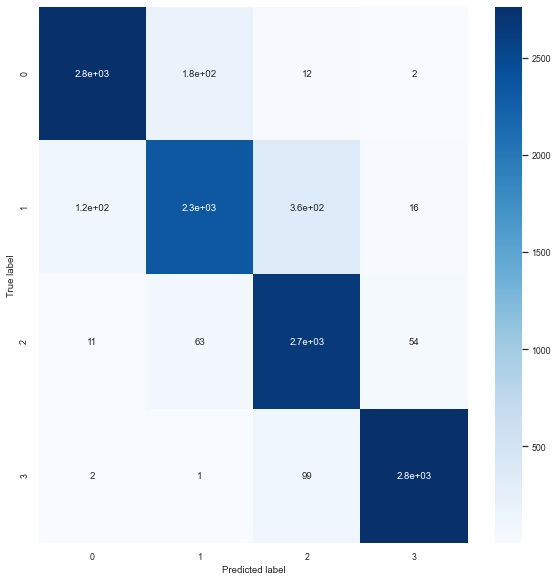

In [43]:
confusion = confusion_matrix(np.argmax(y_test,axis=1), np.argmax(test_data2,axis=1))
figure = plt.figure(figsize=(8, 8))
sns.set(font_scale=0.8)
sns.heatmap(confusion, annot=True,cmap=plt.cm.Blues)
#plt.matshow(confusion)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

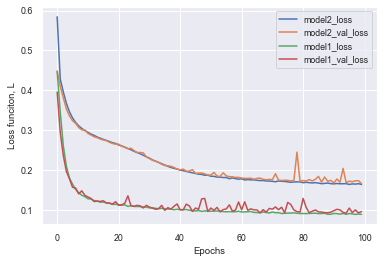

In [44]:
plt.plot(history2.history['loss'],label="model2_loss")
plt.plot(history2.history['val_loss'],label="model2_val_loss")
plt.plot(history.history['loss'],label="model1_loss")
plt.plot(history.history['val_loss'],label="model1_val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss funciton, L")
plt.legend()
plt.show()

From the loss history graphs we observe that our second model has the greatest loss but as the number of epochs cylced inceases the two models begin to converge with the first model having the least amount of loss. From this and the accuracy scores of the two models we can deduce that the first model is the best. Some of the noteworthy hyperparameters for the first model that can explain the difference between the two include the number of hidden layers, the first model had significantly more hidden layers than the second one which has had a significant impact, the deeper the neural network the larger the capacity for it to learn. We also changed the activation function for the output node and reduced the batch size, we cannot understand individually the impact of each hyperparameter without further optimization techniques:

What we find from modifying the hyperparameters of the model is that the accuracy is still very high, this is most likely due to the fact that the training data set is so large that the model has so much information to base its predictions on. We could refine the parameters futher using hyperparameter optimization techniques such as a grid search in which the model systmatically tests multiple values of each hyperparameter by retraining the model looking for the setup which yields the highest accuracy scores. This hasnt been implemented here because of the nature of the dataset, large training sets are long to run and it also scales with the number of hyperparameters being tested.

In conclusion out of all the models we have created to classify the particles we find that the best performing one is the deep neural network classifier providing an accuracy score of ~96% (1 in 20 particles incorrectly classified). The decision trees were much quicker to train and provided high accuracy scores depending on the depth meaning they would be a suitable alternative to the neural networks.